In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from collections import Counter
import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%matplotlib inline

# 数据处理

## 数据加载

In [2]:
# 加载正负评论数据
# pos数据
with open("data/pos.txt", "r") as f:
    pos_text = f.read()

# neg数据
with open("data/neg.txt", "r") as f:
    neg_text = f.read()

## 描述性统计

In [3]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from multiprocessing import Pool
import spacy, string
nlp = spacy.load('en')
# 标点符号
punctuations = string.punctuation
def delete_non_ascii_num(txt):
    return ''.join([i if ord(i) < 128 else '' for i in txt])

def clean_core(doc):
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    tokens = delete_non_ascii_num(tokens)
    return tokens

def cleanup_text(docs, logging=False):
    # 去除停用词
    multiprocess_pool = Pool(64)
    texts = multiprocess_pool.map(clean_core, docs)
    return texts

In [4]:
# 积极文本统计
print("-" * 20 + " POSITIVE TEXT " + "-" * 20)
# 分句
pos_sentences = pos_text.lower().split("\n")
print("Total positive sentences: {}".format(len(pos_sentences)))
print("The average length of positive sentences: {}".format(np.mean([len(sentence.split()) for sentence in pos_sentences])))
print("The max length of positive sentences: {}".format(np.max([len(sentence.split()) for sentence in pos_sentences])))
print("The min length of positive sentences: {}".format(np.min([len(sentence.split()) for sentence in pos_sentences])))
# 统计高频词
c = Counter(pos_text.split()).most_common(10)
print("Most common words in positive sentences: \n{}".format(c))

# 校级文本统计
print()
print("-" * 20 + " NEGATIVE TEXT " + "-" * 20)
# 分句
neg_sentences = neg_text.lower().split("\n")
print("Total negative sentences: {}".format(len(neg_sentences)))
print("The average length of negative sentences: {}".format(np.mean([len(sentence.split()) for sentence in neg_sentences])))
print("The max length of negative sentences: {}".format(np.max([len(sentence.split()) for sentence in neg_sentences])))
print("The min length of negative sentences: {}".format(np.min([len(sentence.split()) for sentence in neg_sentences])))
# 统计高频词
c = Counter(neg_text.split()).most_common(10)
print("Most common words in negative sentences: \n{}".format(c))

-------------------- POSITIVE TEXT --------------------
Total positive sentences: 5331
The average length of positive sentences: 21.0921027949728
The max length of positive sentences: 59
The min length of positive sentences: 2
Most common words in positive sentences: 
[('.', 6972), (',', 5268), ('the', 5051), ('a', 3830), ('and', 3548), ('of', 3311), ('to', 1969), ('is', 1707), ('in', 1338), ('that', 1262)]

-------------------- NEGATIVE TEXT --------------------
Total negative sentences: 5331
The average length of negative sentences: 20.93884824610767
The max length of negative sentences: 56
The min length of negative sentences: 1
Most common words in negative sentences: 
[('.', 7038), ('the', 5045), (',', 4769), ('a', 3451), ('of', 2750), ('and', 2647), ('to', 2264), ('is', 1660), ('in', 1290), ('that', 1208)]


## 数据预处理

- 构造词典Vocabulary
- 构造映射表
- 转换单词为tokens

In [5]:
# 句子最大长度
SENTENCE_LIMIT_SIZE = 30

### 构造词典

我们要基于整个语料来构造我们的词典，由于文本中包含许多干扰词汇，例如仅出现过1次的这类单词。对于这类极其低频词汇，我们可以对其进行去除，一方面能加快模型执行效率，一方面也能减少特殊词带来的噪声。

In [6]:
# 合并pos和neg文本
total_sentences = pos_sentences + neg_sentences
total_sentences = cleanup_text(total_sentences)
# 统计词汇
c = Counter('\n'.join(total_sentences).split())

In [7]:
# 倒序查看词频
sorted(c.most_common(), key=lambda x: x[1])[:5]
# print(*pos_sentences[:10], sep='\n')

[('claud', 1),
 ('segal', 1),
 ('enrapture', 1),
 ('inscrutable', 1),
 ('spiderman', 1)]

In [8]:
# 初始化两个token：pad和unk
vocab = ["<pad>", "<unk>"]

# 去除出现频次为1次的单词
for w, f in c.most_common():
    if f > 1:
        vocab.append(w)

In [9]:
print("The total size of our vocabulary is: {}".format(len(vocab)))

The total size of our vocabulary is: 8336


### 构造映射

In [10]:
# 单词到编码的映射，例如machine -> 10283
word_to_token = {word: token for token, word in enumerate(vocab)}
# 编码到单词的映射，例如10283 -> machine
token_to_word = {token: word for word, token in word_to_token.items()}

### 转换文本

In [113]:
def convert_text_to_token(sentence, word_to_token_map=word_to_token, limit_size=SENTENCE_LIMIT_SIZE):
    """
    根据单词-编码映射表将单个句子转化为token
    
    @param sentence: 句子，str类型
    @param word_to_token_map: 单词到编码的映射
    @param limit_size: 句子最大长度。超过该长度的句子进行截断，不足的句子进行pad补全
    
    return: 句子转换为token后的列表
    """
    # 获取unknown单词和pad的token
    unk_id = word_to_token_map["<unk>"]
    pad_id = word_to_token_map["<pad>"]
    
    # 对句子进行token转换，对于未在词典中出现过的词用unk的token填充
    tokens = [word_to_token_map.get(word, unk_id) for word in sentence.split()]
    tokens_size = len(tokens)
    # Pad
    if len(tokens) < limit_size:
        tokens.extend([0] * (limit_size - len(tokens)))
    # Trunc
    else:
        tokens = tokens[:limit_size]
    
    return tokens,tokens_size

In [114]:
# 对pos文本处理
pos_tokens = []
pos_lens   = []
clean_sentence = []

print('cleaning...')
clean_sentence = cleanup_text(pos_sentences)

print('converting pos to token...')
for sentence in tqdm.tqdm(clean_sentence):
    tokens,size = convert_text_to_token(sentence)
    pos_tokens.append(tokens)
    pos_lens.append(size)

# 对neg文本处理
neg_tokens = []
neg_lens   = []
clean_sentence = []

print('cleaning...')
clean_sentence = cleanup_text(neg_sentences)

print('converting neg to token...')
for sentence in tqdm.tqdm(clean_sentence):
    tokens,size = convert_text_to_token(sentence)
    neg_tokens.append(tokens)
    neg_lens.append(size)

cleaning...


100%|██████████| 5331/5331 [00:00<00:00, 99959.92it/s]

converting pos to token...
cleaning...



100%|██████████| 5331/5331 [00:00<00:00, 148068.57it/s]

converting neg to token...


In [115]:
# 转化为numpy格式，方便处理
pos_tokens = np.array(pos_tokens)
neg_tokens = np.array(neg_tokens)
# 合并所有语料
total_tokens = np.concatenate((pos_tokens, neg_tokens), axis=0)
total_lens   = np.concatenate((pos_lens, neg_lens), axis=0)
total_lens[total_lens > SENTENCE_LIMIT_SIZE] = SENTENCE_LIMIT_SIZE

# 转化为numpy格式，方便处理
print(pos_tokens.shape)
pos_targets = np.ones((pos_tokens.shape[0]))
print(pos_targets.shape)

print(neg_tokens.shape)
neg_targets = np.zeros((neg_tokens.shape[0]))
# 合并所有target
print(neg_targets.shape)
total_targets = np.concatenate((pos_targets, neg_targets), axis=0).reshape(-1, 1)
print(total_targets.shape)


(5331, 30)
(5331,)
(5331, 30)
(5331,)
(10662, 1)


## 构造词向量

我们使用glove预训练好的词向量来做embedding:

- 如果当前词没有对应词向量，则用随机数产生的向量替代
- 如果当前词为< PAD >，则用0向量代替

### 加载glove预训练词向量

In [14]:
# 加载预训练好的glove词向量
with open("data/glove.6B.300d.txt", 'r') as f:
    words = set()
    word_to_vec = {}
    for line in f:
        line = line.strip().split()
        # 当前单词
        curr_word = line[0]
        words.add(curr_word)
        # 当前词向量
        word_to_vec[curr_word] = np.array(line[1:], dtype=np.float32)

In [15]:
print("The number of words which have pretrained-vectors in vocab is: {}".format(len(set(vocab)&set(words))))
print()
print("The number of words which do not have pretrained-vectors in vocab is : {}".format(len(set(vocab))-
                                                                                         len(set(vocab)&set(words))))

The number of words which have pretrained-vectors in vocab is: 8205

The number of words which do not have pretrained-vectors in vocab is : 131


### 构造词向量矩阵

In [16]:
VOCAB_SIZE = len(vocab)  # 9801
EMBEDDING_SIZE = 300

In [17]:
# 初始化词向量矩阵（这里命名为static是因为这个词向量矩阵用预训练好的填充，无需重新训练）
static_embeddings = np.zeros([VOCAB_SIZE, EMBEDDING_SIZE])

for word, token in tqdm.tqdm(word_to_token.items()):
    # 用glove词向量填充，如果没有对应的词向量，则用随机数填充
    word_vector = word_to_vec.get(word, 0.2 * np.random.random(EMBEDDING_SIZE) - 0.1)
    static_embeddings[token, :] = word_vector

# 重置PAD为0向量
pad_id = word_to_token["<pad>"]
static_embeddings[pad_id, :] = np.zeros(EMBEDDING_SIZE)

100%|██████████| 8336/8336 [00:00<00:00, 64499.90it/s]


In [18]:
static_embeddings = static_embeddings.astype(np.float32)

## 辅助函数

### 分割train和test

In [116]:
from sklearn.model_selection import train_test_split
split_x = np.arange(total_tokens.shape[0])

xid_train, xid_test, y_train, y_test = train_test_split(split_x, total_targets, 
                                                        test_size=0.2, random_state=0,
                                                       shuffle=True, stratify=total_targets)

print(len(xid_test), len(y_test))
xid_test, xid_val, y_test, y_val = train_test_split(xid_test, y_test, 
                                                        test_size=0.5, random_state=0,
                                                       shuffle=True, stratify=y_test)

x_train, x_train_len = total_tokens[xid_train], total_lens[xid_train]
x_val  , x_val_len   = total_tokens[xid_val],   total_lens[xid_val]
x_test , x_test_len  = total_tokens[xid_test],  total_lens[xid_test]

2133 2133


## 混淆矩阵

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def draw_confusion_matrix(y_true, y_pred):
    labels = list(set(y_true))
    conf_mat = confusion_matrix(y_true, y_pred, labels = labels) / len(y_true)
    sns.heatmap(conf_mat,annot=True,cmap="Blues")

### get_batch函数

In [118]:
np.random.seed(0)
def get_batch(x, y, batch_size=256, shuffle=True):
    assert x.shape[0] == y.shape[0], print("error shape!")
    # shuffle
    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))

        x = x[shuffled_index]
        y = y[shuffled_index]
    
    # 统计共几个完整的batch
    n_batches = int(x.shape[0] / batch_size)
    
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]
    
        yield x_batch, y_batch

def get_batch_lens(x, y, lens, batch_size=256, shuffle=True):
    assert x.shape[0] == y.shape[0], print("error shape!")
    # shuffle
    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))

        x = x[shuffled_index]
        y = y[shuffled_index]
        l = lens[shuffled_index]
    
    # 统计共几个完整的batch
    n_batches = int(x.shape[0] / batch_size)
    
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]
        l_batch = lens[i*batch_size: (i+1)*batch_size]

    
        yield x_batch, y_batch, l_batch

# DNN模型

## 构建模型图

<img src="images/dnn.png" style="width:500;height:500px;">

In [47]:
# 清空图
tf.reset_default_graph()

# 定义神经网络超参数
HIDDEN_SIZE   = 16
LEARNING_RATE = 1e-3


with tf.name_scope("dnn"):
    # 输入及输出tensor
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
        prob = tf.placeholder_with_default(1.0, shape=())
    
    # embeddings
    with tf.name_scope("embeddings"):
        # 用pre-trained词向量来作为embedding层
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        
        # 相加词向量得到句子向量
        sum_embed = tf.reduce_sum(embed, axis=1, name="sum_embed")
        
    # model
    with tf.name_scope("model"):

        dense1 = tf.layers.dense(sum_embed, 
                                 units=HIDDEN_SIZE, 
                                 use_bias=True,
                                 activation=tf.nn.relu,
                                 name="dense1")
        
        drop1 = tf.layers.dropout(dense1, rate=prob, seed=0,name="dropout1")
        
        
        dense2 = tf.layers.dense(drop1, 
                         units=1, 
                         use_bias=True,
                         activation=None,
                          name="outputs")
        
        outputs = tf.nn.sigmoid(dense2)
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=dense2))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        
    # evaluation
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.greater(outputs, 0.5), tf.float32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

In [48]:
print([len(x) for x in [x_train, x_val, x_test]])

[8529, 1067, 1066]


## 训练模型

In [49]:
EPOCHES       = 100
BATCH_SIZE    = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/dnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch in get_batch(x_train, y_train, BATCH_SIZE, True):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, 
                                                targets: y_batch, 
                                                prob: 0.5})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/dnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

Epoch: 10, Train loss: 0.4561, Train accuracy: 0.7629, Val accuracy: 0.7385
Epoch: 20, Train loss: 0.3955, Train accuracy: 0.8010, Val accuracy: 0.7423
Epoch: 30, Train loss: 0.3412, Train accuracy: 0.8298, Val accuracy: 0.7179
Epoch: 40, Train loss: 0.2988, Train accuracy: 0.8510, Val accuracy: 0.7067
Epoch: 50, Train loss: 0.2682, Train accuracy: 0.8669, Val accuracy: 0.6917
Epoch: 60, Train loss: 0.2423, Train accuracy: 0.8784, Val accuracy: 0.6973
Epoch: 70, Train loss: 0.2154, Train accuracy: 0.8945, Val accuracy: 0.7010
Epoch: 80, Train loss: 0.1962, Train accuracy: 0.9047, Val accuracy: 0.6973
Epoch: 90, Train loss: 0.1781, Train accuracy: 0.9077, Val accuracy: 0.6926
Epoch: 100, Train loss: 0.1675, Train accuracy: 0.9127, Val accuracy: 0.6926


[best] epoch: 16, val-accuracy 0.7460
INFO:tensorflow:Restoring parameters from checkpoints/dnn_best
The dnn model accuracy on test set: 0.6961


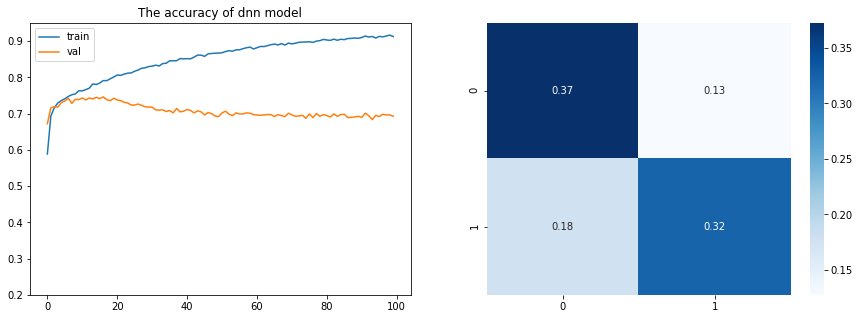

In [50]:
model_type = 'dnn'
best_epoch = np.argmax(nn_val_accuracy)
print("[best] epoch: {}, val-accuracy {:.4f}".format(best_epoch, nn_val_accuracy[best_epoch]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nn_train_accuracy)
plt.plot(nn_val_accuracy)
plt.ylim(ymin=0.2, ymax=0.95)
plt.title("The accuracy of {} model".format(model_type))
plt.legend(["train", "val"])

plt.subplot(1,2,2)
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/{}_best".format(model_type))
    acc_v,preds_v = sess.run([accuracy, preds],
                    feed_dict={ inputs: x_test, 
                                targets: y_test})
    draw_confusion_matrix(y_test.squeeze().tolist(), preds_v.squeeze().tolist())
    print("The {} model accuracy on test set: {:.4f}".format(model_type, acc_v / x_test.shape[0]))

plt.savefig('dnn_1.png',dpi=400,pad_inches=0.0,bbox_inches='tight')

在命令行执行tensorboard --logdir="./graphs/dnn" --port 6006可以看到模型的tensorboard

<img src="images/dnn-tensorboard.png" style="width:500;height:500px;">

# RNN模型

## 构建模型图

In [119]:
# 清空图
tf.reset_default_graph()

# 定义网络超参数
HIDDEN_SIZE = 8
LEARNING_RATE = 1e-3
KEEP_PROB = 0.5


with tf.name_scope("rnn"):
    # placeholders
    with tf.name_scope("placeholders"):
        inputs     = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        input_lens = tf.placeholder(dtype=tf.int32, shape=(None, ), name="inputs_lens")

        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
        prob = tf.placeholder_with_default(1.0, shape=())
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
    
    # model
    with tf.name_scope("model"):
        # 构造lstm单元
        lstm = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
        # 添加dropout
        drop_lstm = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=prob, seed=2)
        _, lstm_state = tf.nn.dynamic_rnn(drop_lstm, embed, dtype=tf.float32, sequence_length=input_lens)
        
        outputs = tf.layers.dense(lstm_state.h, 
                         units=1, 
                         use_bias=True,
                         activation=None)
        
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=outputs))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.greater(outputs, 0.5), tf.float32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [120]:
EPOCHES = 100
BATCH_SIZE = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/rnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch, l_batch in get_batch_lens(x_train, y_train, x_train_len, BATCH_SIZE, True):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, 
                                                targets: y_batch, 
                                                input_lens: l_batch,
                                                prob: 0.5})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val, input_lens: x_val_len})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/rnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

Epoch: 10, Train loss: 0.4792, Train accuracy: 0.7377, Val accuracy: 0.7320
Epoch: 20, Train loss: 0.4016, Train accuracy: 0.7900, Val accuracy: 0.7376
Epoch: 30, Train loss: 0.3402, Train accuracy: 0.8273, Val accuracy: 0.7301
Epoch: 40, Train loss: 0.2895, Train accuracy: 0.8558, Val accuracy: 0.7254
Epoch: 50, Train loss: 0.2699, Train accuracy: 0.8649, Val accuracy: 0.7291
Epoch: 60, Train loss: 0.2373, Train accuracy: 0.8819, Val accuracy: 0.7320
Epoch: 70, Train loss: 0.2168, Train accuracy: 0.8951, Val accuracy: 0.7235
Epoch: 80, Train loss: 0.2069, Train accuracy: 0.8981, Val accuracy: 0.7170
Epoch: 90, Train loss: 0.2237, Train accuracy: 0.8898, Val accuracy: 0.6917
Epoch: 100, Train loss: 0.1688, Train accuracy: 0.9171, Val accuracy: 0.7160


[best] epoch: 12, val-accuracy 0.7432
INFO:tensorflow:Restoring parameters from checkpoints/rnn_best
The rnn model accuracy on test set: 0.7308


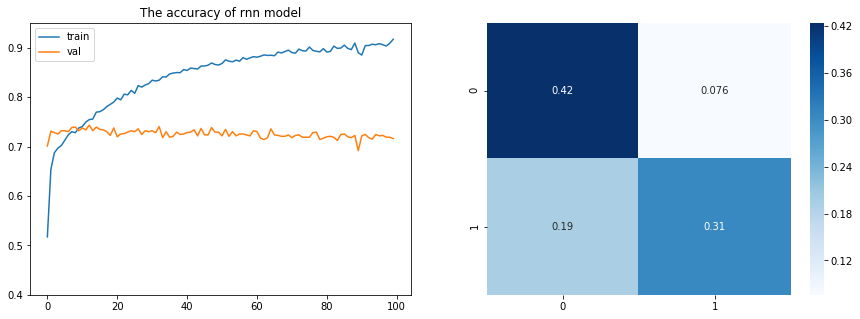

In [121]:
model_type = 'rnn'
best_epoch = np.argmax(nn_val_accuracy)
print("[best] epoch: {}, val-accuracy {:.4f}".format(best_epoch, nn_val_accuracy[best_epoch]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nn_train_accuracy)
plt.plot(nn_val_accuracy)
plt.ylim(ymin=0.4, ymax=0.95)
plt.title("The accuracy of {} model".format(model_type))
plt.legend(["train", "val"])

plt.subplot(1,2,2)
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/{}_best".format(model_type))
    acc_v,preds_v = sess.run([accuracy, preds],
                    feed_dict={ inputs: x_test, 
                                targets: y_test,
                                 input_lens: x_test_len})
    draw_confusion_matrix(y_test.squeeze().tolist(), preds_v.squeeze().tolist())
    print("The {} model accuracy on test set: {:.4f}".format(model_type, acc_v / x_test.shape[0]))

plt.savefig('rnn_test1.png',dpi=400,pad_inches=0.0,bbox_inches='tight')

# CNN模型

## 构建模型图

In [105]:
# 清空图
tf.reset_default_graph()

# 我在这里定义了e种filter，每种100个
filters_size = [3, 4, 5]
num_filters = 100
# 超参数
LEARNING_RATE = 1e-3
L2_LAMBDA     = 3
KEEP_PROB     = 0.5

with tf.name_scope("cnn"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 30), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
        prob = tf.placeholder_with_default(1.0, shape=())
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 添加channel维度
        embed_expanded = tf.expand_dims(embed, -1, name="embed_expand")
    
    # 用来存储max-pooling的结果
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            filter_shape = [filter_size, EMBEDDING_SIZE, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, SENTENCE_LIMIT_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    padding="VALID",
                                    name="max_pooling")
            pooled_outputs.append(max_pooling)
    
    # 统计所有的filter
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    # dropout
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, prob, seed=2)
    
    # output
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 1), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(dropout, W), b)
        predictions = tf.nn.sigmoid(logits, name="predictions")
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.greater(predictions, 0.5), tf.float32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

## 训练模型

In [106]:
EPOCHES = 100
BATCH_SIZE = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/cnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch in get_batch(x_train, y_train, BATCH_SIZE, True):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, 
                                                targets: y_batch, 
                                                prob: 0.5})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/cnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

Epoch: 10, Train loss: 0.5028, Train accuracy: 0.7788, Val accuracy: 0.7441
Epoch: 20, Train loss: 0.4396, Train accuracy: 0.8231, Val accuracy: 0.7507
Epoch: 30, Train loss: 0.3833, Train accuracy: 0.8676, Val accuracy: 0.7554
Epoch: 40, Train loss: 0.3436, Train accuracy: 0.8941, Val accuracy: 0.7479
Epoch: 50, Train loss: 0.3081, Train accuracy: 0.9161, Val accuracy: 0.7573
Epoch: 60, Train loss: 0.2773, Train accuracy: 0.9328, Val accuracy: 0.7432
Epoch: 70, Train loss: 0.2499, Train accuracy: 0.9442, Val accuracy: 0.7591
Epoch: 80, Train loss: 0.2292, Train accuracy: 0.9517, Val accuracy: 0.7413
Epoch: 90, Train loss: 0.2085, Train accuracy: 0.9571, Val accuracy: 0.7404
Epoch: 100, Train loss: 0.1967, Train accuracy: 0.9593, Val accuracy: 0.7413


[best] epoch: 63, val-accuracy 0.7648
INFO:tensorflow:Restoring parameters from checkpoints/cnn_best
The cnn model accuracy on test set: 0.7514


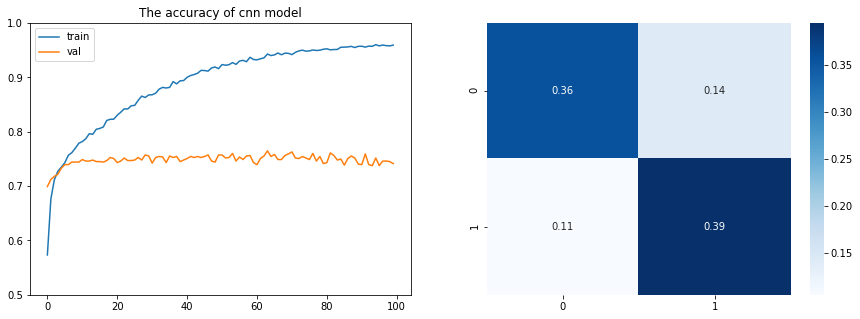

In [108]:
model_type = 'cnn'
best_epoch = np.argmax(nn_val_accuracy)
print("[best] epoch: {}, val-accuracy {:.4f}".format(best_epoch, nn_val_accuracy[best_epoch]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nn_train_accuracy)
plt.plot(nn_val_accuracy)
plt.ylim(ymin=0.5, ymax=1)
plt.title("The accuracy of {} model".format(model_type))
plt.legend(["train", "val"])

plt.subplot(1,2,2)
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/{}_best".format(model_type))
    acc_v,preds_v = sess.run([accuracy, preds],
                    feed_dict={ inputs: x_test, 
                                targets: y_test})
    draw_confusion_matrix(y_test.squeeze().tolist(), preds_v.squeeze().tolist())
    print("The {} model accuracy on test set: {:.4f}".format(model_type, acc_v / x_test.shape[0]))

plt.savefig('cnn_1.png',dpi=400,pad_inches=0.0,bbox_inches='tight')

In [247]:
print(len(x_train), len(x_test))

8529 2133
